In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.patches import Rectangle
import pandas as pd
import random
from matplotlib.ticker import ScalarFormatter

In [2]:
def read_text_file(file_path, delimiter='\s+', header=None):
    dataframe = pd.read_csv(file_path, delimiter=delimiter, header=header)
    return dataframe

In [3]:
def construct_particle(Energy, particletype, xmin, xmax, r):
    H3mass=3.02382
    alphamass=4.001506
    ret=[]
    #note Qvalue is (14.087+8.071-2.425-14.95=4.783 MeV)
    if particletype=="t":
        outgoingenergy=(4.783+Energy)*alphamass/(H3mass+alphamass)
    if particletype=="a":
        outgoingenergy=(4.783+Energy)*H3mass/(H3mass+alphamass)
    xi=np.random.uniform(0, 1)
    macro=10   
    x=xi*xmax*.98
#     -np.log(xi)/macro    #np.random.uniform(xmax*.3, xmax*.7) #not xsec based for now
#     if x>xmax:
#       x=xmax*.99
    y=np.random.uniform(0, r)
    z=np.random.uniform(0,((r**2-y**2)**(1/2)))
    position=[x,y,z]
    position=np.asarray(position)
    xhat=np.random.uniform(0,1) #one of the particles will go in +x direction
    yhat=np.random.uniform(-1,1)
    zhat=np.random.uniform(-1,1)
    normal = [xhat, yhat, zhat]
    normal=np.asarray(normal)
    normal=np.multiply(normal,(1/np.linalg.norm(normal)))
    ret.append(position)
    ret.append(normal)
    ret.append(np.asarray([outgoingenergy]))
    return np.asarray(ret)

In [4]:
#ex: formula of the form [2,1] for Z of [1,8] to make H2O. M is molar mass
def meanExcitationEnergy(Z, M, formula, density):
    I=[]
    N=[]
    moleculeI=0
    counter=0
    for i in Z:
        if i==1:
            I.append(19)
        if i>1 and i<13:
            I.append(11.2+11.7*i)
        if i>13:
            I.append(52.8+8.81*i)
        N.append(density/(M)*6.023E23*formula[counter]*i)
        moleculeI+=(np.log(I[counter])*N[counter])
        counter+=1
    Ncompound=np.sum(N)
    moleculeI=moleculeI/Ncompound
    moleculeI=np.exp(moleculeI)
    ret=[]
    ret.append(moleculeI)
    ret.append(Ncompound)
    return np.asarray(ret)

In [5]:
#provide Energy in MeV
def collisionalSPSiC(Energy, z):
    mEE=meanExcitationEnergy([14,6], 40, [1,1], 3.22)
#     z=2 #2 for alpha
    r_0=2.818e-13
    electronrestmass=0.511
    Beta=((1 - (3727 /(Energy+3727))**2)**(1/2)) #3727 is the mass of an alpha particle in MeV*c^2
    I=mEE[0]
    N=mEE[1]
    logterm=(np.log(2*.511e6*Beta**2/(I*(1-Beta**2)))-Beta**2)
    return 4*np.pi*(z**2)*(r_0**2)*electronrestmass*(Beta**(-2))*N*logterm

In [6]:
def collisionalSPLiF(Energy, z):
    mEE=meanExcitationEnergy([3,9], 25, [1,1], 2.64)
#     z=2 #2 for alpha
    r_0=2.818e-13
    electronrestmass=0.511
    Beta=((1 - (3727 /(Energy+3727))**2)**(1/2)) #3727 is the mass of an alpha particle in MeV*c^2
    I=mEE[0]
    N=mEE[1]
    logterm=(np.log(2*.511e6*Beta**2/(I*(1-Beta**2)))-Beta**2)
    return 4*np.pi*(z**2)*(r_0**2)*electronrestmass*(Beta**(-2))*N*logterm

In [7]:
def energyDeposited(incidentenergy, particletype, xmin, xmax, r): #xmax here is the max for the LiF layer only
  coinflip=random.randint(1,2) #triton and alpha are generated at the same time in opp. directions
  if coinflip==2:
    particletype='a'
  particle=construct_particle(incidentenergy/1e6, particletype, xmin, xmax, r)
  if particletype=='t':
    z=1
  if particletype=='a':
    z=2
  dEdx = collisionalSPLiF(particle[2][0], z)

  Range= particle[2][0]/dEdx
  final_pos=np.multiply(Range,particle[1])+particle[0] #add straggle error later maybe
  LiFmax=(detectorx1-detectorx0) #LiF layer max
  SiCmax=(detectorx3-detectorx0) #ACTIVE SiC layer max
#r=.2481 inherited
  if final_pos[0]>LiFmax:

    #path length in LiF
      scalar=(LiFmax-particle[0][0])/particle[1][0]
      LiF_pos=np.multiply(scalar,particle[1])+particle[0]
      LiFpath=((LiF_pos[0]-particle[0][0])**2+(LiF_pos[1]-particle[0][1])**2+(LiF_pos[2]-particle[0][2])**2)**(1/2)
      RemainingEnergy = particle[2][0]-(LiFpath*dEdx)
      dEdx = collisionalSPSiC(RemainingEnergy, z)
      Range= RemainingEnergy/dEdx
      final_pos=np.multiply(Range,particle[1])+LiF_pos
    
    #total path length
      path=(((final_pos[0]-LiF_pos[0])**2+(final_pos[1]-LiF_pos[1])**2+(final_pos[2]-LiF_pos[2])**2)**(1/2))
      #print (path)
      if final_pos[0]>SiCmax:
        scalar3=(SiCmax-particle[0][0])/particle[1][0]
        SiC_pos=np.multiply(scalar3,particle[1])+particle[0]
        SiCpath=((SiC_pos[0]-LiF_pos[0])**2+(SiC_pos[1]-LiF_pos[1])**2+(SiC_pos[2]-LiF_pos[2])**2)**(1/2)
        path=SiCpath
       
    #path length to detector boundary
      a=particle[0][1]
      b=particle[1][1]
      c=particle[0][2]
      d=particle[1][2]
      e=(b**2+d**2) #e x^2
      f=2*(a*b+c*d) #f x
      g=(a**2+c**2-r**2) #g
      if ((final_pos[1]**2+final_pos[2]**2)**(1/2))>r:
          scalar2=(-f+(f**2-4*e*g)**(1/2))/(2*e)
          #print(scalar2)
          detector_pos=np.multiply(scalar2,particle[1])+particle[0]
          detectorpath=((detector_pos[0]-particle[0][0])**2+(detector_pos[1]-particle[0][1])**2+(detector_pos[2]-particle[0][2])**2)**(1/2)
          if LiF_pos[0] > detector_pos[0]:
            path = 0
          else:
            path=detectorpath-LiFpath
    #energy deposition
      energy_deposited= path*dEdx
      if dEdx<0:
          energy_deposited=RemainingEnergy
  else:
    energy_deposited=0
  if energy_deposited < 0:
    print (path)
#     print (final_pos[0]>LiFmax)
# #     print (RemainingEnergy)
#     print (dEdx)
#     print (final_pos)
#     print (LiF_pos)
#     print (Range)
# #     print (particle[2][0])
# #     print (energy_deposited, Range*dEdx)
  return (energy_deposited*1E6)

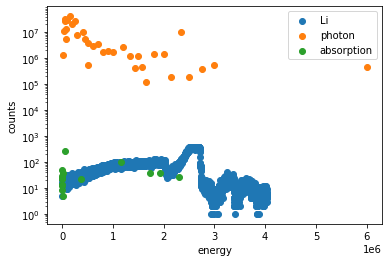

135
392
57854
80054
265632
239173


In [10]:
file_path = 'C:/Users/kevak/Desktop/pastLi.txt'

df = read_text_file(file_path)
column_names = ['group', 'upper energy', 'value', 'uncertainty', 'rel']
df.columns = column_names
df=df.drop('group', axis=1)

file_path = 'C:/Users/kevak/Desktop/pastphoton.txt'

df2 = read_text_file(file_path)
column_names = ['group', 'upper energy', 'value', 'uncertainty', 'rel']
df2.columns = column_names

file_path = 'C:/Users/kevak/Desktop/pastabs.txt'

df3 = read_text_file(file_path)
column_names = ['group', 'upper energy', 'value', 'uncertainty', 'rel']
df3.columns = column_names

detectorx0=89
detectorx1=detectorx0+.00028
detectorx2=detectorx1+0.0008
detectorx3=detectorx2+.015
detectorx4=detectorx3+.035
detectorx5=detectorx4+.0008
radius=.2481
speclist =[]

for i in df.index:
  avgenergy=(df.loc[i, 'upper energy'])
  #print (len(df))
  for j in range(0, round((df.loc[i, 'value'])/18.7*5.41E-04)):  
    #spec = energyDeposited(avgenergy, 't', 0, (detectorx1-detectorx0), radius)
    spec = energyDeposited(avgenergy, 't', 0, (detectorx1-detectorx0), radius)
    speclist.append(spec)
    
speclist = np.asarray(speclist)
elist = speclist[speclist.nonzero()]
roundedlist = np.round(elist, -3)
series = pd.Series(roundedlist)
counts = series.value_counts().reset_index()
counts.columns = ['roundedlist', 'mean']
counts['mean']*=1

df2 = df2[df2['value'] != 0]
df3 = df3[df3['value'] != 0]
df2['value']*=2.9E-3
df3['value']*=2.9E-3

# Create the plot
plt.figure()
plt.scatter(counts['roundedlist'], counts['mean'], label='Li')
plt.scatter(df2['upper energy'], df2['value'], label='photon')
plt.scatter(df3['upper energy'], df3['value'], label='absorption')

# Add labels and legend
plt.xlabel('energy')
plt.ylabel('counts')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# Show the plot
plt.show()

filtered = counts[(counts['roundedlist'] >= 1.5e6) & (counts['roundedlist'] <= 2.2e6)]
filtered2 = counts[(counts['roundedlist'] >= 2.5e6) & (counts['roundedlist'] <= 3e6)]
filtered3 = counts[(counts['roundedlist'] >= 0.3e6)]
filtered4 = counts[(counts['roundedlist'] >= 0.9e6)]

print (filtered['mean'].max())
print (filtered2['mean'].max())
print (filtered['mean'].sum())
print (filtered2['mean'].sum())
print (filtered3['mean'].sum())
print (filtered4['mean'].sum())

<function matplotlib.pyplot.show(close=None, block=None)>

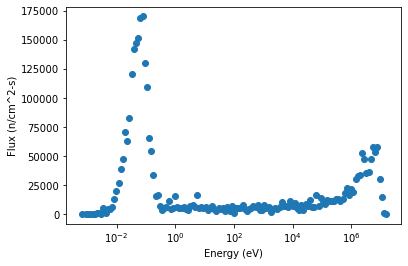

In [11]:
file_path = 'C:/Users/kevak/Desktop/polyflux20.txt'

df4 = read_text_file(file_path)
column_names = ['group', 'upper energy', 'value', 'uncertainty', 'rel', 'a', 'b', 'c']
df4.columns = column_names
df4=df4.drop('group', axis=1)
df4 = df4[df4['value'] != 0]
# Print the dataframe
plt.scatter(df4['upper energy'], df4['value'], label='flux')
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy (eV)')
plt.ylabel('Flux (n/cm^2-s)')
plt.show